### Imports

In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from models.modeling import VisionTransformer, CONFIGS

import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from collections import defaultdict

import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Preparing arguments

In [2]:
class Args:
    pass

args = Args()
args.vit_config = "ViT-L_16"
args.frozen_weights_flag = False
args.frozen_weights = ""
if(args.frozen_weights_flag):
    args.frozen_weights = "weights_frozen"
else:
    args.frozen_weights = "weights_not_frozen"
args.num_classes = 8
args.batch_size = 32
args.resolution = 224

### Dataset preparation

In [3]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}

In [4]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

train_images = np.load(os.path.join(data_src_folder, 'train_images.npy'))
train_labels = np.load(os.path.join(data_src_folder, 'train_labels.npy'))

val_images = np.load(os.path.join(data_src_folder, 'val_images.npy'))
val_labels = np.load(os.path.join(data_src_folder, 'val_labels.npy'))

test_images = np.load(os.path.join(data_src_folder, 'test_images.npy'))
test_labels = np.load(os.path.join(data_src_folder, 'test_labels.npy'))

print(f"train_images shape: {train_images.shape}, train_labels shape: {train_labels.shape}")
print(f"train_images shape: {val_images.shape}, train_labels shape: {val_labels.shape}")
print(f"train_images shape: {test_images.shape}, train_labels shape: {test_labels.shape}")

train_images shape: (28389, 48, 48), train_labels shape: (28389, 8)
train_images shape: (3546, 48, 48), train_labels shape: (3546, 8)
train_images shape: (3553, 48, 48), train_labels shape: (3553, 8)


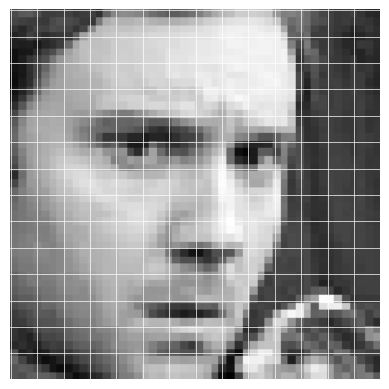

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image = train_images[0]

height, width = 224, 224

orig_height, orig_width = image.shape

scale_y = height / orig_height
scale_x = width / orig_width

y_indices = (np.arange(height) / scale_y).astype(int)
x_indices = (np.arange(width) / scale_x).astype(int)

resized_image = image[y_indices[:, None], x_indices]

plt.imshow(resized_image, cmap='gray')

cell_size = 16
for x in range(0, width, cell_size):
    plt.axvline(x, color='white', linestyle='-', linewidth=0.5)

for y in range(0, height, cell_size):
    plt.axhline(y, color='white', linestyle='-', linewidth=0.5)

plt.axis('off')
plt.show()


In [11]:
train_images[0]

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]])

In [12]:
train_labels[0]

array([0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [13]:
class FERP_PreDataset(Dataset):
  def __init__(self, x_face, y_lab, transform):
    super(FERP_PreDataset,self).__init__()
    self.x_face = x_face
    self.y_lab = y_lab
    self.transform = transform 

  def __len__(self):
    return len(self.y_lab)
  
  def __getitem__(self, index):
    image_face = self.x_face[index]
    label = self.y_lab[index]
    
    image_face = np.array(image_face, dtype=np.uint8)
    image_face = cv2.cvtColor(image_face, cv2.COLOR_GRAY2RGB)

    return self.transform(image_face), torch.tensor(label, dtype=torch.float32)

In [14]:
batch_size = args.batch_size

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((args.resolution, args.resolution)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((args.resolution, args.resolution)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

train_dataset = FERP_PreDataset(train_images, train_labels, \
                                  train_transform)
val_dataset = FERP_PreDataset(val_images, val_labels, \
                                test_transform)
test_dataset = FERP_PreDataset(test_images, test_labels, \
                                 test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))

train loader  887 val loader  111 test 112


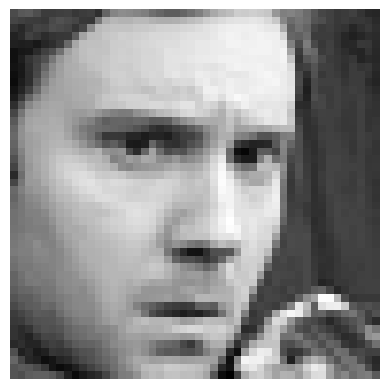

In [15]:
plt.imshow(train_images[0], cmap='gray')
plt.axis('off')
plt.show()

torch.Size([3, 224, 224])
tensor([0., 0., 0., 0., 0., 0., 1., 0.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


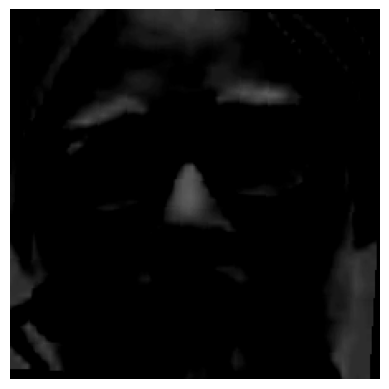

In [10]:
### testing one image

image, label = train_dataset[1]

print(image.shape)
print(label)

plt.axis('off')

plt.imshow(image.permute(1, 2, 0))
plt.show()

### MODELS

In [12]:
config = CONFIGS[args.vit_config]
model = VisionTransformer(config, num_classes=args.num_classes, zero_head=True, img_size=args.resolution, vis=True)
model.load_from(np.load("C:\\BME\\7_felev\\szakdoli\\code\\ViT-pytorch\\attention_data\\ViT-L_16-224.npz"))
model.eval()
model_name = f"{args.vit_config}_{args.resolution}x{args.resolution}_b{args.batch_size}_{args.frozen_weights}_dataaug"

In [13]:
model_name

'ViT-L_16_224x224_b32_weights_not_frozen_dataaug'

In [14]:
criterion = torch.nn.CrossEntropyLoss()

if args.frozen_weights_flag:
    print("frozen weights")
    optimizer = optim.Adam(model.head.parameters(), lr = 5e-4)

    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.head.parameters():
        param.requires_grad = True
else:
    print("not frozen weights")
    optimizer = optim.Adam(model.parameters(), lr = 2e-4)

    for param in model.parameters():
        param.requires_grad = True
        
    for param in model.head.parameters():
        param.requires_grad = True

not frozen weights


In [15]:
image, label = train_dataset[0]

output, att_mat = model(image.unsqueeze(0))

In [16]:
print(len(att_mat))
att_mat = torch.stack(att_mat)
print(att_mat.size())
att_mat = att_mat.squeeze(1)
print(att_mat.size())

24
torch.Size([24, 1, 16, 197, 197])
torch.Size([24, 16, 197, 197])


#### Device

In [17]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

GPU: NVIDIA GeForce RTX 3060 Laptop GPU is available.


#### Training

In [ ]:
def train_model(device, epochs, model, optimizer, f_loss, early_stopping, train_loader, val_loader, model_dir, model_name):
    # initializing
    min_loss = np.inf
    no_improvement = 0
    train_loss = list()
    train_accuracy = list()
    val_loss = list()
    val_accuracy = list()
    
    vit_model = model
    
    for e in range(epochs):
        running_loss, running_accuracy = 0.0, 0.0
        total, correct = 0, 0 # for accuracy calculation
        
        vit_model.to(device)
        vit_model.train()
        
        for images_face, y_labels in iter(train_loader):
            images_face = images_face.to(device)
            y_labels = y_labels.to(device)
            
            optimizer.zero_grad() # zeroing out gradients - previous epochs don't matter
            
            (batch_output, attn_weights) = vit_model(images_face)
            
            # calculating loss for batch and adding it to running_loss
            loss = f_loss(batch_output, y_labels)
            running_loss += loss.item()
            
            # calculating accuracy for batch and adding it to running_accuracy
            _, pred_emotion = torch.max(batch_output, 1)
            _, label_emotion = torch.max(y_labels, 1)
            total += y_labels.size(0)
            correct += (pred_emotion == label_emotion).sum().item()
            
            # additional steps - backprop and opt step
            loss.backward()
            optimizer.step()
        
        running_loss /= len(train_loader)
        running_accuracy = 100 * correct / total
        
        print(f"epoch = {e}")
        print(f"\tTraining loss = {running_loss}")
        print(f"\tTraining accuracy = {running_accuracy}")
        
        train_loss.append(running_loss)
        train_accuracy.append(running_accuracy)
        
        running_loss, running_accuracy = 0.0, 0.0
        total, correct = 0, 0
        
        vit_model.eval()
        
        with torch.no_grad():
            for images_face, y_labels in iter(val_loader):
                images_face = images_face.to(device)
                y_labels = y_labels.to(device)
                
                (batch_output, attn_weights) = vit_model(images_face)
                
                # calculating loss for batch and adding it to running_loss
                loss = f_loss(batch_output, y_labels)
                running_loss += loss.item()
                
                # calculating accuracy for batch and adding it to running_accuracy
                _, pred_emotion = torch.max(batch_output, 1)
                _, label_emotion = torch.max(y_labels, 1)
                total += y_labels.size(0)
                correct += (pred_emotion == label_emotion).sum().item()
                
            
            running_loss /= len(val_loader)
            running_accuracy = 100 * correct / total
                
            print(f"\tValidation loss = {running_loss}")
            print(f"\tValidation accuracy = {running_accuracy}")
            
            val_loss.append(running_loss)
            val_accuracy.append(running_accuracy)
        
        # seeing if model has improved or not
        if(val_loss[-1] < min_loss):
            min_loss = val_loss[-1]
            no_improvement = 0
            
            print(f"Val loss has decreased, saving model at {e} epoch")
            
            vit_model.to("cpu")
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            
            torch.save(vit_model, model_dir + f"\\{model_name}.pth")
            vit_model.to(device)
        else:
            no_improvement += 1
            print(f"Loss has not decreased. Early stopping in {early_stopping - no_improvement} epochs")
            
        if no_improvement == early_stopping:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
            f.suptitle('ViT Loss and Accuracy')

            ax1.plot(range(0, len(train_loss)), train_loss, color='blue')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss', color='blue')
            ax1.legend(['train loss'], loc='upper left')

            ax1_2 = ax1.twinx()
            ax1_2.plot(range(0, len(train_accuracy)), train_accuracy, color='green')
            ax1_2.set_ylabel('Accuracy', color='green')
            ax1_2.legend(['train accuracy'], loc='upper right')

            ax2.plot(range(0, len(val_loss)), val_loss, color='red')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Loss', color='red')
            ax2.legend(['val loss'], loc='upper left')

            ax2_2 = ax2.twinx()
            ax2_2.plot(range(0, len(val_accuracy)), val_accuracy, color='orange')
            ax2_2.set_ylabel('Accuracy', color='orange')
            ax2_2.legend(['val accuracy'], loc='upper right')

            plt.tight_layout()
            plt.show()
            return
        
        print("-------")
            
            
    print("Training completed")
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    f.suptitle('ViT Loss and Accuracy')

    # Plotting train and val loss
    ax1.plot(range(0, len(train_loss)), train_loss, color='blue')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='blue')
    ax1.legend(['train loss'], loc='upper left')

    # Adding a secondary y-axis for train accuracy
    ax1_2 = ax1.twinx()
    ax1_2.plot(range(0, len(train_accuracy)), train_accuracy, color='green')
    ax1_2.set_ylabel('Accuracy', color='green')
    ax1_2.legend(['train accuracy'], loc='upper right')

    # Plotting val loss
    ax2.plot(range(0, len(val_loss)), val_loss, color='red')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss', color='red')
    ax2.legend(['val loss'], loc='upper left')

    # Adding a secondary y-axis for val accuracy
    ax2_2 = ax2.twinx()
    ax2_2.plot(range(0, len(val_accuracy)), val_accuracy, color='orange')
    ax2_2.set_ylabel('Accuracy', color='orange')
    ax2_2.legend(['val accuracy'], loc='upper right')

    plt.tight_layout()
    plt.show()

In [72]:
i, l = train_dataset[0]

# model_name += "_v2"
print(model_name)
print(i.shape)

ViT-L_16_224x224_b32_weights_not_frozen_dataaug
torch.Size([3, 224, 224])


In [ ]:
import time
start = time.time()
train_model(device=device, epochs=1, model=model,
            optimizer=optimizer, f_loss=criterion, early_stopping=5,
            train_loader=train_loader, val_loader=val_loader,
            model_dir="C:\\BME\\7_felev\\szakdoli\\models\\model_checkpoints_ferp_nosave",
            model_name=model_name)
end = time.time()

print(f"Time: {(end - start):.4f}")

#### Testing

In [18]:
model_dir="C:\\BME\\7_felev\\szakdoli\\models\\model_checkpoints_ferp"
model_name = "ViT-L_16_224x224_b24_weights_not_frozen_dataaug"

model_path = f"{model_dir}\\{model_name}.pth"

model = torch.load(model_path)

In [19]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

GPU: NVIDIA GeForce RTX 3060 Laptop GPU is available.


In [86]:
def test_model(model, test_loader, criterion, device, loader_name):
    model.eval()
    model.to(device)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            (outputs, attn_weights) = model(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            _, label_emotions = torch.max(labels, 1)
            
            total += labels.size(0)
            correct += (predicted == label_emotions).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total

    print(f"{loader_name} Loss: {avg_loss:.4f}, {loader_name} Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy


In [ ]:
avg_loss_train, accuracy_train = test_model(model, train_loader, criterion, device, "Train")

In [76]:
avg_loss_train, accuracy_train = test_model(model, val_loader, criterion, device, "Val")

Val Loss: 0.4917, Val Accuracy: 82.35%


In [77]:
avg_loss_train, accuracy_train = test_model(model, test_loader, criterion, device, "Test")

Test Loss: 0.5104, Test Accuracy: 82.52%


In [42]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

### Attention map

In [20]:
def get_emotion_for_prediction(pred):
    emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}
    max_index = torch.argmax(pred)
    return emotions[max_index.item()]

In [24]:
def test_with_picture_from_internet(model, picture_path):
    model.to('cpu')
    transform = transforms.Compose([
    transforms.Resize((args.resolution, args.resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    image = Image.open(picture_path)
    image = image.convert("RGB")
    x = transform(image)
    
    output, att_mat = model(x.unsqueeze(0))
    
    f = nn.Softmax()
    output = f(output)
    
    emotion = get_emotion_for_prediction(output)
    
    print(f"Prediction: {output}")
    print(f"Model has predicted: {emotion}")

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    ax1.axis('off')
    ax2.axis('off')
    _ = ax1.imshow(image)
    _ = ax2.imshow(image)
    _ = ax2.imshow(mask, cmap='jet', alpha = 0.6)

Prediction: tensor([[0.0247, 0.0085, 0.0054, 0.0565, 0.0824, 0.0148, 0.7945, 0.0133]],
       grad_fn=<SoftmaxBackward0>)
Model has predicted: Neutral


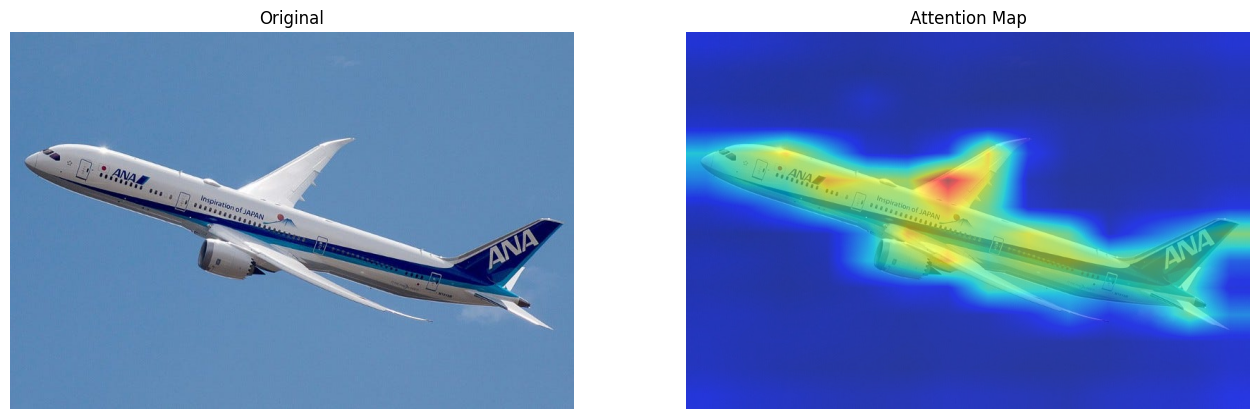

In [37]:
test_with_picture_from_internet(model, "test_images_internet\\airplane_2.jpg")

In [63]:
def test_with_picture_from_ferp(model, image, label, grey2brg_flage = True):
    model.to('cpu')
    transform = transforms.Compose([
        transforms.Resize((args.resolution, args.resolution)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    image = np.array(image, dtype=np.uint8)
    if grey2brg_flage:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = Image.fromarray(image)
    x = transform(image)
    
    output, att_mat = model(x.unsqueeze(0))
    
    f = nn.Softmax()
    output = f(output)
    
    label_emotion = np.argmax(label)
    print(f"Label: {label_emotion}")
    label_emotion = emotions[label_emotion]
    emotion = get_emotion_for_prediction(output)
    
    
    print(f"Prediction: {output}")
    print(f"Label: {label_emotion}")
    print(f"Model has predicted: {emotion}")

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(image)
    _ = ax2.imshow(mask, cmap='jet', alpha = 0.6)
    
    return mask

Label: 6
Prediction: tensor([[1.6045e-03, 2.1389e-04, 3.6364e-04, 1.1105e-04, 3.7514e-02, 7.9691e-04,
         9.5749e-01, 1.9104e-03]], grad_fn=<SoftmaxBackward0>)
Label: Neutral
Model has predicted: Neutral


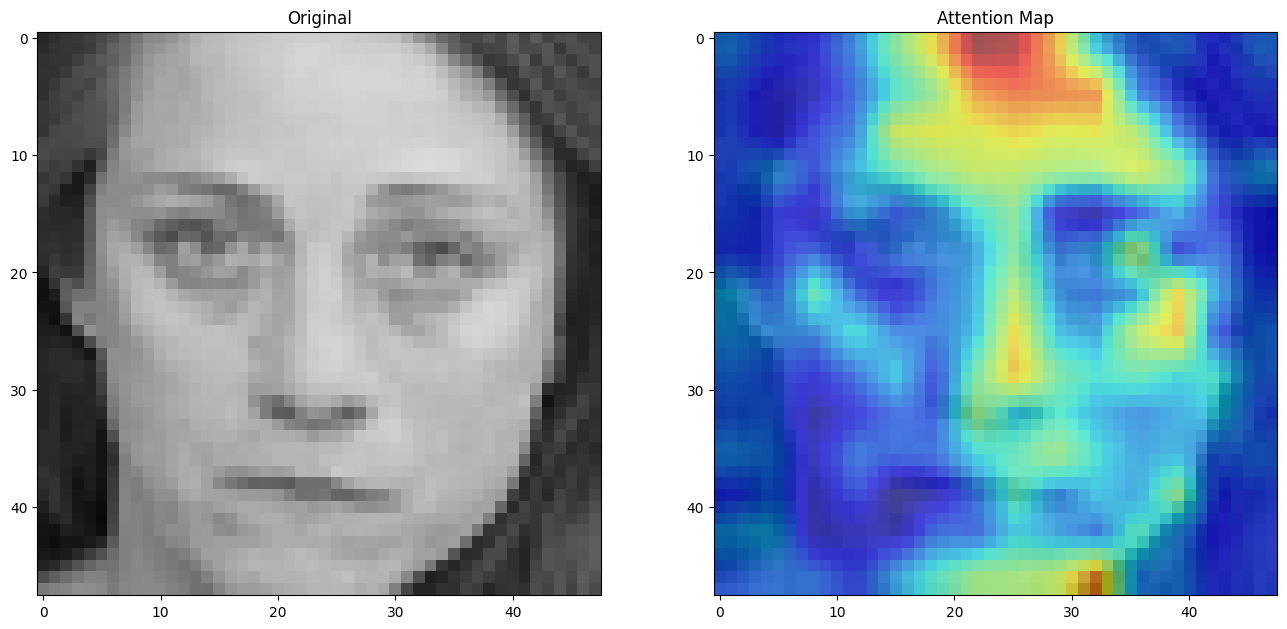

In [64]:
i = 3200
image = test_images[i]
label = test_labels[i]
mask = test_with_picture_from_ferp(model, image, label, True)

### Confusion matrix

In [87]:
def calculate_confusion_matrix(model, data_loader, device):
    model.to(device)
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for i, (images, targets) in tqdm(
            enumerate(data_loader), total = len(data_loader), leave = False
        ):
            images = images.to(device)
            targets = targets.to(device)
            
            goodtargets = []
            
            for target in range(len(targets)):
                goodtargets.append(np.where(targets.cpu()[target] == 1)[0][0])
                
            outputs, att_map = model(images)
            predictions = outputs.argmax(dim=1)
            all_targets.extend(np.array(goodtargets))
            all_predictions.extend(predictions.cpu().numpy())
    
    return confusion_matrix(all_targets, all_predictions)

In [88]:
matrix = calculate_confusion_matrix(model, test_loader, device)

In [89]:
def plot_confusion_matrix(conf_matrix, normalize=False):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(emotions))
    plt.xticks(tick_marks, [emotions[i] for i in range(len(emotions))], rotation = 45)
    plt.yticks(tick_marks, [emotions[i] for i in range(len(emotions))])
    
    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Prediction Label")
    plt.show()
    a = ""
    if normalize:
        a = "_normalized"
    plt.close()

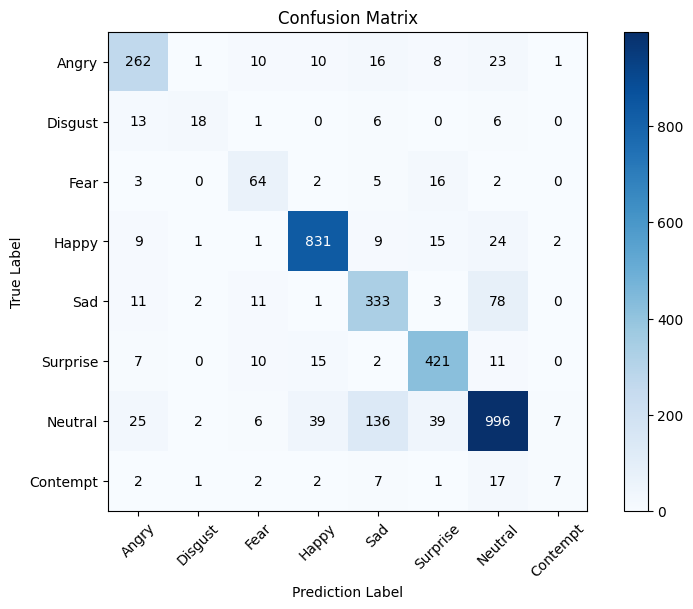

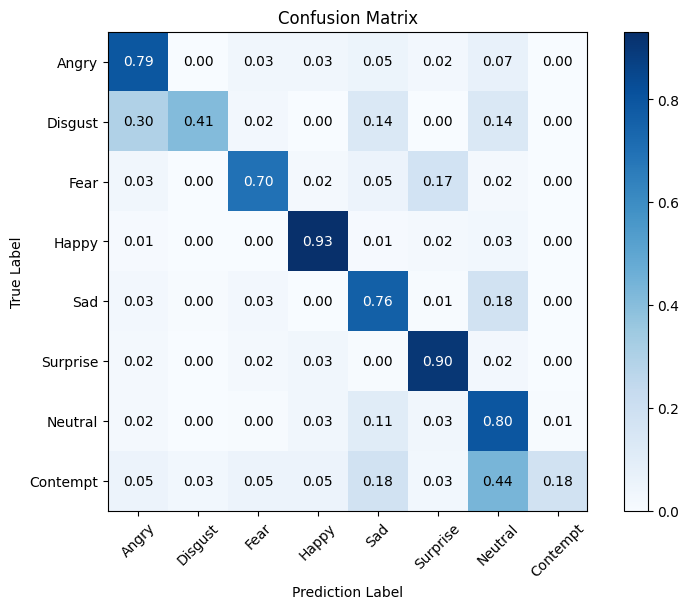

In [90]:
plot_confusion_matrix(matrix, False)
plot_confusion_matrix(matrix, True)

### Averaging Attention Maps

#### Prepare dataset

In [21]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

normal_test_images = np.load(os.path.join(data_src_folder, 'matrix_normal_test.npy'))
transformed_test_images = np.load(os.path.join(data_src_folder, 'matrix_transformed_test.npy'))
normal_test_labels = np.load(os.path.join(data_src_folder, 'matrix_normal_test_label.npy'))

print(f"Normal shape: {normal_test_images.shape}")
print(f"Transformed shape: {transformed_test_images.shape}")
print(f"Normal labels shape: {normal_test_labels.shape}")

Normal shape: (3154, 48, 48)
Transformed shape: (3154, 224, 224, 3)
Normal labels shape: (3154, 8)


In [22]:
class FERP_PreDataset_AttMapAvg(Dataset):
  def __init__(self, x_face, trafo_face, y_lab, transform):
    super(FERP_PreDataset_AttMapAvg,self).__init__()
    self.x_face = x_face
    self.trafo_face = trafo_face
    self.y_lab = y_lab
    self.transform = transform 

  def __len__(self):
    return len(self.y_lab)
  
  def __getitem__(self, index):
    image_face = self.x_face[index]
    image_trafo_face = self.trafo_face[index]
    label = self.y_lab[index]
    
    image_face = np.array(image_face, dtype=np.uint8)
    image_face = cv2.cvtColor(image_face, cv2.COLOR_GRAY2RGB)

    return self.transform(image_face), self.transform(image_trafo_face), torch.tensor(label, dtype=torch.float32)

In [23]:
batch_size = 32

att_map_test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                     ])

att_map_test_dataset = FERP_PreDataset_AttMapAvg(normal_test_images, transformed_test_images, normal_test_labels, \
                                                 att_map_test_transform)

att_map_test_loader = DataLoader(att_map_test_dataset, batch_size, shuffle=False)

print(f"att_map_test_loader: {len(att_map_test_loader)}")

att_map_test_loader: 99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


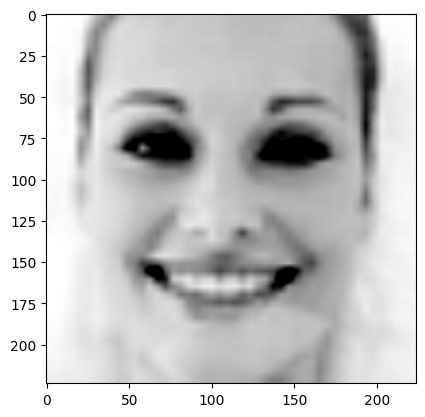

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


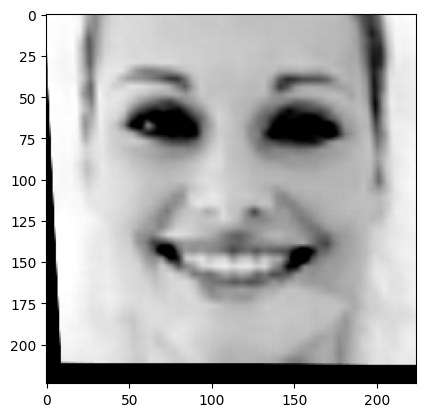

In [36]:
image, image_tf, label = att_map_test_dataset[1234]

plt.imshow(image.permute(1, 2, 0))
plt.show()

plt.imshow(image_tf.permute(1, 2, 0))
plt.show()

In [24]:
def test_model_trafo(model, test_loader, criterion, device, loader_name):
    model.eval()
    model.to(device)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, transformed_inputs, labels in test_loader:
            transformed_inputs = transformed_inputs.to(device)
            labels = labels.to(device)

            (outputs, attn_weights) = model(transformed_inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            _, label_emotions = torch.max(labels, 1)
            
            total += labels.size(0)
            correct += (predicted == label_emotions).sum().item()

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total

    print(f"{loader_name} Loss: {avg_loss:.4f}, {loader_name} Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy


loss, acc = test_model_trafo(model, att_map_test_loader, criterion, device, "transformed dataset")

transformed dataset Loss: 0.5461, transformed dataset Accuracy: 80.85%


#### Average attention maps for each class then plot the result

In [37]:
# calculating attention mask based on a given attention matrix
def get_attention_mask(att_mat, size):
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)
    att_mat = att_mat.to('cpu')
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), size)[..., np.newaxis]
    
    return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


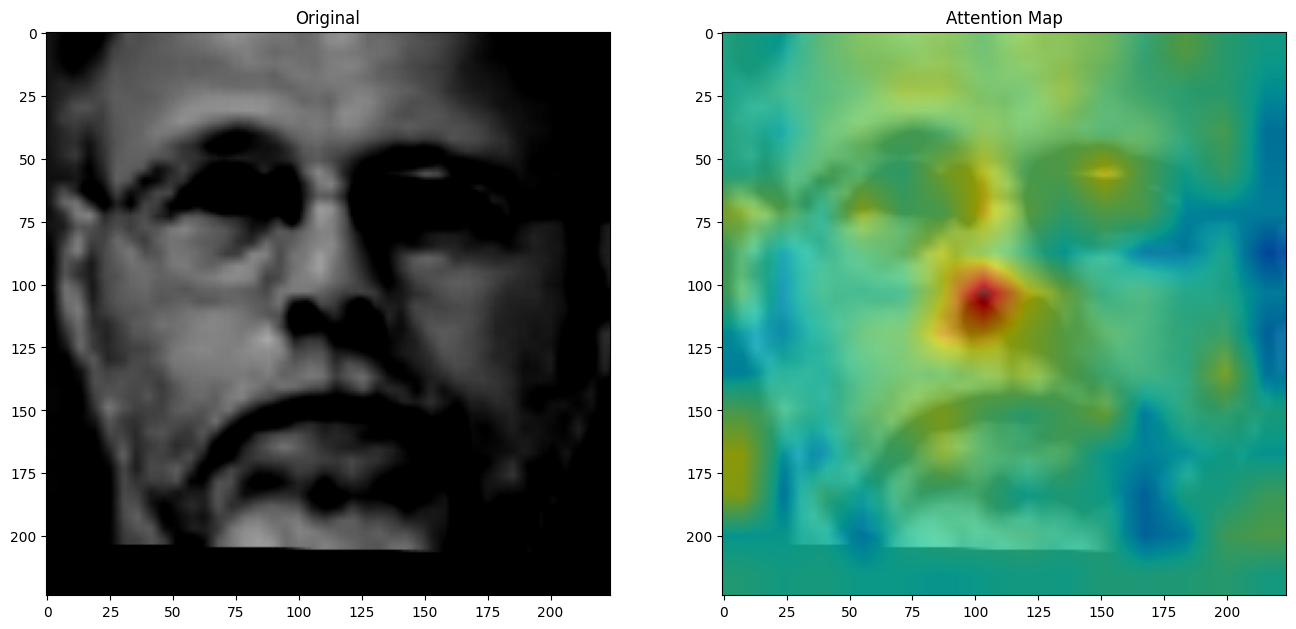

In [43]:
model.eval()
model.to(device)

transformed_face, normal_face, label = att_map_test_dataset[876]

normal_face = normal_face.to(device)
label = label.to(device)

output, att_map = model(normal_face.unsqueeze(0))

# print(output)
# print(label)
mask = get_attention_mask(att_map, ((normal_face.shape[1], normal_face.shape[2])))

normal_face = normal_face.to('cpu')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(normal_face.permute(1, 2, 0))
_ = ax2.imshow(normal_face.permute(1, 2, 0))
_ = ax2.imshow(mask, cmap='jet', alpha=0.6, vmin=0, vmax=1)


In [ ]:
def translate_image(image, translation):
    translation_matrix = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

def rotate_image(image, center, angle):
    center = (int(center[1]), int(center[0]))
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return rotated_image

def zoom_image(image, zoom_factor, target_size=(224, 224)):
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2

    if zoom_factor > 1:
        crop_width = int(image.shape[1] / zoom_factor)
        crop_height = int(image.shape[0] / zoom_factor)

        x1 = center_x - crop_width // 2
        x2 = center_x + crop_width // 2
        y1 = center_y - crop_height // 2
        y2 = center_y + crop_height // 2

        x1, x2 = max(0, x1), min(image.shape[1], x2)
        y1, y2 = max(0, y1), min(image.shape[0], y2)

        cropped_image = image[y1:y2, x1:x2]

        zoomed_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_LINEAR)
    elif zoom_factor == 1:
        zoomed_image = image
    else:  # zoom_factor < 1
        new_width = int(image.shape[1] / zoom_factor)
        new_height = int(image.shape[0] / zoom_factor)

        padded_image = np.zeros((new_height, new_width, 3), dtype=image.dtype)

        start_x = (new_width - image.shape[1]) // 2
        start_y = (new_height - image.shape[0]) // 2

        padded_image[start_y:start_y + image.shape[0], start_x:start_x + image.shape[1]] = image

        zoomed_image = cv2.resize(padded_image, (target_size[1], target_size[0]))

        
    return zoomed_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


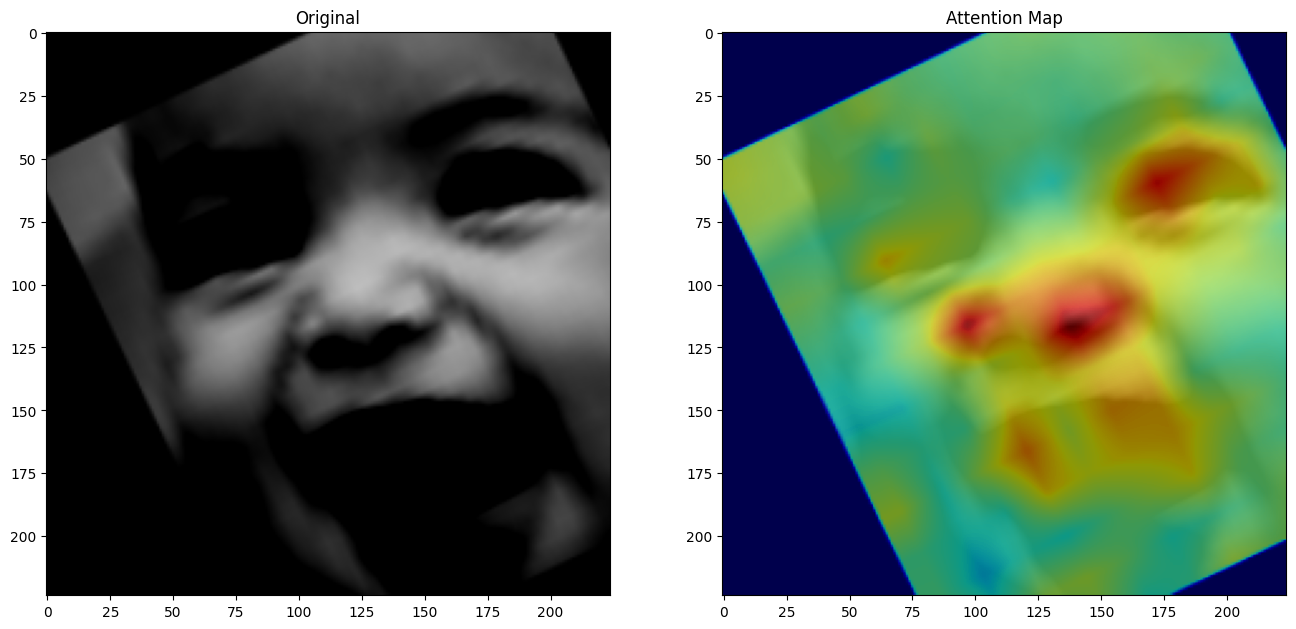

In [116]:
translation = [43, 22]
rotation_angle = 25.58851314131642
zoom_factor = 1.143277775931343

normal_face_np = mask
translated_image = translate_image(normal_face_np, translation)

center = np.array([int(normal_face_np.shape[0] / 2), int(normal_face_np.shape[1] / 2)])
rotated_image = rotate_image(translated_image, center, rotation_angle)


final_mask = zoom_image(rotated_image, zoom_factor)

normal_face_np = np.array(normal_face.permute(1, 2, 0))
translated_image = translate_image(normal_face_np, translation)


center = np.array([int(normal_face_np.shape[0] / 2), int(normal_face_np.shape[1] / 2)])
rotated_image = rotate_image(translated_image, center, rotation_angle)

final_image = zoom_image(rotated_image, zoom_factor)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(final_image)
_ = ax2.imshow(final_image)
_ = ax2.imshow(final_mask, cmap='jet', alpha = 0.6, vmin=0, vmax=1)

In [46]:
# attention masks for classes function
def get_attention_masks_for_classes(att_map_dataset):
    num_classes = 8
    masks = [[] for _ in range(num_classes)]

    model.eval()
    model.to(device)

    with torch.no_grad():
        for i in range(len(att_map_dataset)):
            if i % 500 == 0: print(i)
            normal_face, transformed_face, label = att_map_dataset[i]
            
            transformed_face = transformed_face.to(device)
            label = label.to(device)
            
            output, att_map = model(transformed_face.unsqueeze(0))
            
            label_max = torch.argmax(label)
            output_max = torch.argmax(output)
            
            if(label_max == output_max):
                mask = get_attention_mask(att_map, (transformed_face.shape[1], transformed_face.shape[2]))
                masks[label_max].append(mask)
                
    return masks

In [47]:
# calculating attention masks
masks = get_attention_masks_for_classes(att_map_test_dataset)

angry_masks = np.array(masks[0])
disgust_masks = np.array(masks[1])
fear_masks = np.array(masks[2])
happy_masks = np.array(masks[3])
sad_masks = np.array(masks[4])
surprise_masks = np.array(masks[5])
neutral_masks = np.array(masks[6])
contempt_masks = np.array(masks[7])

0
500
1000
1500
2000
2500
3000


In [48]:
# saving masks to computer
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_pm_matrix"

np.save(os.path.join(data_src_folder, 'angry_masks_224.npy'), angry_masks)
np.save(os.path.join(data_src_folder, 'disgust_masks_224.npy'), disgust_masks)
np.save(os.path.join(data_src_folder, 'fear_masks_224.npy'), fear_masks)
np.save(os.path.join(data_src_folder, 'happy_masks_224.npy'), happy_masks)
np.save(os.path.join(data_src_folder, 'sad_masks_224.npy'), sad_masks)
np.save(os.path.join(data_src_folder, 'surprise_masks_224.npy'), surprise_masks)
np.save(os.path.join(data_src_folder, 'neutral_masks_224.npy'), neutral_masks)
np.save(os.path.join(data_src_folder, 'contempt_masks_224.npy'), contempt_masks)

In [49]:
# mask average function
def average_masks(masks):
    masks_sum = np.zeros((masks.shape[1], masks.shape[2], masks.shape[3]))
    for i in range(masks.shape[0]):
        masks_sum += masks[i]
        
    masks_avg = masks_sum / masks.shape[0]
    
    return masks_avg

In [60]:
#data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_pm"
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_pm_matrix"

angry_masks = np.load(os.path.join(data_src_folder, "angry_masks_224.npy"))
disgust_masks = np.load(os.path.join(data_src_folder, "disgust_masks_224.npy"))
fear_masks = np.load(os.path.join(data_src_folder, "fear_masks_224.npy"))
happy_masks = np.load(os.path.join(data_src_folder, "happy_masks_224.npy"))
sad_masks = np.load(os.path.join(data_src_folder, "sad_masks_224.npy"))
surprise_masks = np.load(os.path.join(data_src_folder, "surprise_masks_224.npy"))
neutral_masks = np.load(os.path.join(data_src_folder, "neutral_masks_224.npy"))
contempt_masks = np.load(os.path.join(data_src_folder, "contempt_masks_224.npy"))

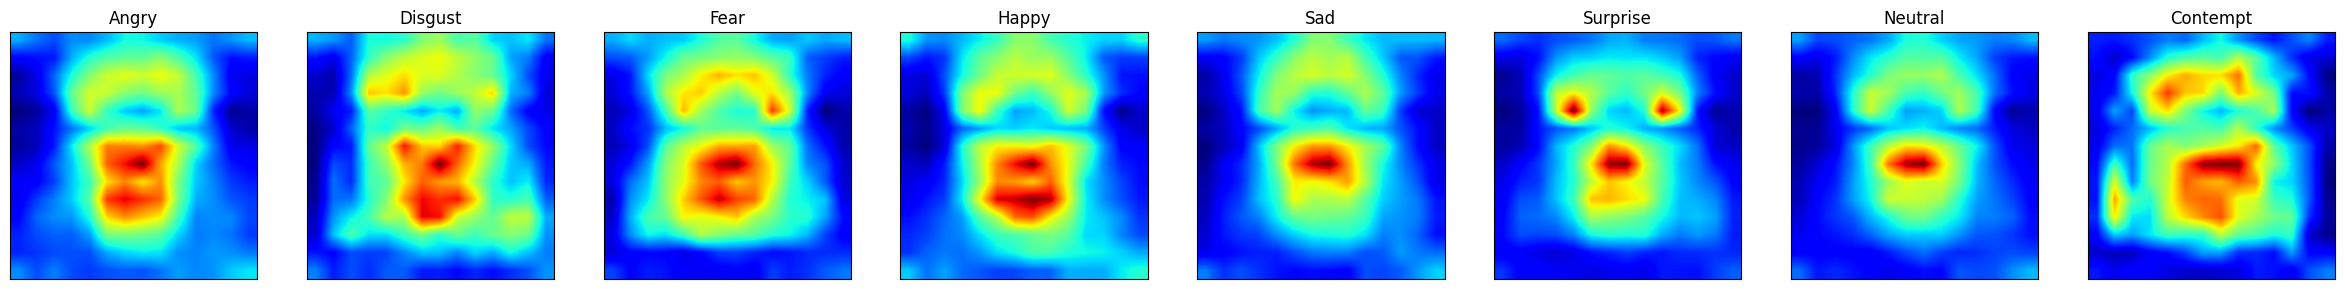

In [61]:
mask_dict = {0: angry_masks, 1: disgust_masks, 2: fear_masks, 3: happy_masks, 4: sad_masks, 5: surprise_masks, 6: neutral_masks, 7: contempt_masks}

def plot_all_mask_averages():
    fig, axs = plt.subplots(1, 8, figsize=(30, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axs = axs.ravel()
    for i in range(8):
        average_mask = average_masks(mask_dict[i])
        axs[i].imshow(average_mask)
        axs[i].imshow(average_mask, cmap='jet', alpha = 1)
        axs[i].set_title(emotions[i])
        axs[i].set_xticks([])  # Remove x ticks
        axs[i].set_yticks([])  # Remove y ticks

    plt.show()
    
plot_all_mask_averages()

#### Retrieving landmark mask for attention mask averages above

In [12]:
class FERP_PreDataset(Dataset):
  def __init__(self, x_face, y_lab, transform):
    super(FERP_PreDataset,self).__init__()
    self.x_face = x_face
    self.y_lab = y_lab
    self.transform = transform 

  def __len__(self):
    return len(self.y_lab)
  
  def __getitem__(self, index):
    image_face = self.x_face[index]
    label = self.y_lab[index]
    
    image_face = np.array(image_face, dtype=np.uint8)
    image_face = cv2.cvtColor(image_face, cv2.COLOR_GRAY2RGB)

    return self.transform(image_face), torch.tensor(label, dtype=torch.float32)

In [13]:
batch_size = 32

test_transform_mask = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224, 224))])

test_dataset_mask = FERP_PreDataset(test_images, test_labels, \
                                 test_transform_mask)

test_loader_mask = DataLoader(test_dataset_mask, batch_size, shuffle=False) 

print ('test', len(test_loader_mask))

test 112


In [14]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

model_path_local = 'C:\\BME\\7_felev\\szakdoli\\models\\mediapipe\\face_landmarker_v2_with_blendshapes.task'

base_options = python.BaseOptions(model_asset_path=model_path_local)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                        output_face_blendshapes=True,
                                        output_facial_transformation_matrixes=True,
                                        num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [15]:
# Visualization code by google
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import drawing_utils_copy


def draw_landmarks_on_image(rgb_image, detection_result, ):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    drawing_utils_copy.draw_landmarks_grayscale(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    drawing_utils_copy.draw_landmarks_grayscale(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    drawing_utils_copy.draw_landmarks_grayscale(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

91.02197536858887
translation: [  6 -17], rotation: 1.259045207175268 scaling factor: 0.6591814752100583
91.02197536858887


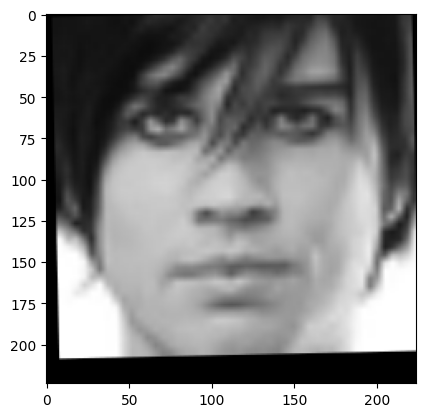

In [16]:
# run face detector for one image and plot result
# 675 is good! for basic face mask
i = 675
image, label = test_dataset_mask[i]

image = np.array(image, dtype=np.uint8)

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
detection_result = detector.detect(mp_image)

# normalizer code from mediapipe

from typing import List, Mapping, Optional, Tuple, Union
import math

def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def get_detection_result_for_image(image, detector):
    image = np.array(image, dtype=np.uint8)
    
    image = mp.Image(image_format = mp.ImageFormat.SRGB, data = image)
    detection_result = detector.detect(image)
    
    return detection_result

def calculate_transformation_values_for_image(detection_result, image_width, image_height):
    nose_3d = detection_result.face_landmarks[0][4]
    forehead_3d = detection_result.face_landmarks[0][151]
    
    nose = _normalized_to_pixel_coordinates(nose_3d.x, nose_3d.y, image_width, image_height)
    forehead = _normalized_to_pixel_coordinates(forehead_3d.x, forehead_3d.y, image_width, image_height)
    if nose != None and forehead != None:
        nose_x, nose_y = nose
        forehead_x, forehead_y = forehead
        nose_2d = np.array([nose_x, nose_y])
        forehead_2d = np.array([forehead_x, forehead_y])
        center = np.array([int(image_height / 2), int(image_width / 2)])
        
        translation = center - nose_2d
        
        rotation_multiplier = -1
        if (forehead_2d - nose_2d)[0] > 0: rotation_multiplier = 1
        
        distance_nose_forehead = np.linalg.norm(nose_2d - forehead_2d)
        translated_forehead_2d = forehead_2d + translation
        rotated_forehead_2d = center + np.array([0, -distance_nose_forehead])
        
        scaling_factor = 60 / distance_nose_forehead
        print(distance_nose_forehead)
        
        b = np.linalg.norm(translated_forehead_2d - rotated_forehead_2d) / 2
        c = distance_nose_forehead
        
        rotation_angle = math.degrees(2 * math.asin(b / c))
        
        return translation, rotation_angle * rotation_multiplier, scaling_factor
    else:
        return None
    
    
translation, rotation_angle, scaling_factor = calculate_transformation_values_for_image(detection_result, 224, 224)
print(f"translation: {translation}, rotation: {rotation_angle} scaling factor: {scaling_factor}")

def translate_image(image, translation):
    translation_matrix = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

def rotate_image(image, center, angle):
    # Convert the center from NumPy array to a tuple
    center = (int(center[1]), int(center[0]))  # OpenCV expects (x, y) format
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)  # Center coordinates are x, y
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return rotated_image

def zoom_image(image, zoom_factor, target_size=(224, 224)):
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2

    if zoom_factor > 1:
        crop_width = int(image.shape[1] / zoom_factor)
        crop_height = int(image.shape[0] / zoom_factor)
    else:
        crop_width = int(image.shape[1] * (1 / zoom_factor))
        crop_height = int(image.shape[0] * (1 / zoom_factor))

    x1 = center_x - crop_width // 2
    x2 = center_x + crop_width // 2
    y1 = center_y - crop_height // 2
    y2 = center_y + crop_height // 2

    x1, x2 = max(0, x1), min(image.shape[1], x2)
    y1, y2 = max(0, y1), min(image.shape[0], y2)
    
    cropped_image = image[y1:y2, x1:x2]

    zoomed_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_LINEAR)
    return zoomed_image

# Transformation for one image

translation, rotation_angle, zoom_factor = calculate_transformation_values_for_image(detection_result, image.shape[1], image.shape[0])

translated_image = translate_image(image, translation)

center = np.array([int(image.shape[0] / 2), int(image.shape[1] / 2)])
rotated_image = rotate_image(translated_image, center, rotation_angle)

final_image = zoom_image(rotated_image, zoom_factor, target_size=(224, 224))

plt.imshow(final_image)
plt.show()

In [17]:
final_mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=final_image)
detection_result = detector.detect(final_mp_image)